$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\renewcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\renewcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
$$

# Part 6: YOLO - Objects Detection
<a id=part6></a>

In this part we will use an object detection architecture called YOLO (You only look once) to detect objects in images. We'll use an already trained model weights (v5) found here: https://github.com/ultralytics/yolov5

In [1]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the YOLO model
model = torch.hub.load("ultralytics/yolov5", "yolov5s")
model.to(device)
# Images
img1 = 'imgs/DolphinsInTheSky.jpg'  
img2 = 'imgs/cat-shiba-inu-2.jpg' 

Using cache found in /home/ofer.nissim/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-25 Python-3.8.12 torch-1.10.1 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


## Inference with YOLO
<a id=part6_1></a>

You are provided with 2 images (img1 and img2).
**TODO**:
1. Detect objects using the YOLOv5 model for these 2 images.
2. Print the inference output with bounding boxes.
3. Calculate the number of pixels within a bounding box and the number in the background.
   
   **Hint**: Given you stored the model output in a varibale named 'results', you may find 'results.pandas().xyxy' helpful 
4. Look at the inference results and answer the question below.


Results for image 1:


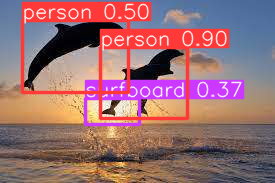

         xmin       ymin        xmax        ymax  confidence  class       name
0  100.278381  47.370995  187.863556  118.462662    0.903491      0     person
1   22.531363  20.887983  128.905212   92.257050    0.500973      0     person
2   85.617989  98.014702  139.018356  124.627922    0.367016     37  surfboard

- Number of Bounded Pixels:  13162
- Number of Background Pixels: 37163


Results for image 2:


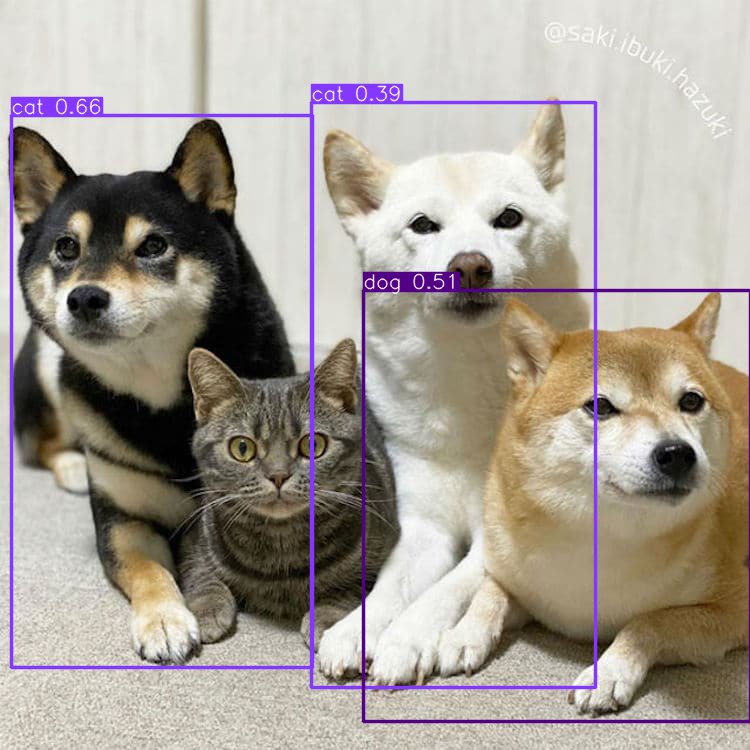

         xmin        ymin        xmax        ymax  confidence  class name
0   11.568563  115.774918  312.757080  667.323730    0.655977     15  cat
1  363.715485  290.178558  750.000000  721.983826    0.509416     16  dog
2  311.190765  102.437584  595.031799  687.870605    0.391701     15  cat

- Number of Bounded Pixels:  406233
- Number of Background Pixels: 156267




In [2]:
#Insert the inference code here.
import cv2

from shapely.geometry import Polygon
from shapely.geometry import box
from shapely.ops import unary_union


def get_boxes_unified_area(results):
    polygons = []
    objects = results.pandas().xyxy[0]
    
    for current_box in range(len(objects)):
        boundaries_coordinates = objects.iloc[current_box][:4]
        polygons.append(Polygon(box(*boundaries_coordinates)))
        
    # unify all the polygons boxes and get the unified area
    return unary_union(polygons).area 

def results_show(im_path):
    results_show.i += 1
    # Inference
    results = model(im_path)
    
    # Get number of pixels within a bounding box
    num_pixels_bounded_box = get_boxes_unified_area(results)
    
    # Get number of pixels in the background
    img = cv2.imread(im_path)
    num_pixels_total = img.shape[0] * img.shape[1]
    
    # show the results
    print("\033[1m" +f"Results for image {results_show.i}:")
    results.show()
    print(results.pandas().xyxy[0])
    print(f"\n- Number of Bounded Pixels:  {num_pixels_bounded_box:.0f}\n- Number of Background Pixels: {(num_pixels_total - num_pixels_bounded_box):.0f}\n\n") 


results_show.i = 0
results_show(img1)
results_show(img2)


### Question 1

Analyze the inference results of the 2 images. 
1. How well did the model detect the objects in the pictures?
2. What can possibly be the reason for the model failures? suggest methods to resolve that issue.

In [3]:
from cs236781.answers import display_answer
import hw2.answers

In [4]:
display_answer(hw2.answers.part6_q1)



**Your answer:**

1. The model managed to detect the boundaries of the objects in the pictures generally well, but its classifications were mostly wrong. 
It can be seen in the first picture, where two dolphins were classified as persons and the tail of the third one was classified as a surfboard.
In the second picture, two dogs were classified as cats and the cat was not detected at all.
We'll also notice that the dog that was classified correctly had a score of 0.51, which implies a significant level of uncertainty.
All in all, the model's performance was not good for these 2 pictures.  
2. We'll examine numerous reasons for the model failures and suggest compatible solutions for the issues:  
- A possible reason for the model failure is lack of light/dark images, which makes objects' features less noticeable and produces difficulties in the models classification.
This can be resolved by adding brightness to the images, changing their contrast rate or using similar lighting techniques.  
- Another possible reason for the model failures can be a missing class, on which the model was not trained - like in the first picture, where it's seems like there is no dolphin class exists.
The solution for that issue is to train the model to classify dolphins in addition to the existing classes.  
- Furthermore, a bias that is related to image setup in the training phase could lead to a misclassification of objects. 
For example, in the first image there is a background of sea surface, sun and sky, which might cause the model to classify the dolphins as humans - 
in case it was trained on pictures of humans with beach background and on pictures of dolphins with underwater background. 
To solve this problem, more pictures of each class can be provided for the training, containing different backgrounds in order to prevent this kind of classification bias.  
- Looking at the second picture, the overlapping of the objects (occlusion) might cause misclassification or missing detection of an object.
A solution for that might involve some spatial manipulations like rotation, cropping or resizing some objects in the pictures.
We'll mention that the YOLO model's algorithm divides the image into a grid of boxes, and tries to detect+classify an object in each box according to its center.
Adjusting the number of boxes in the grid (equivalent to changing the boxes' sizes) could improve the model's performance in this situation.


## Creative Detection Failures

<a id=part6_2></a>

Object detection pitfalls could be, for example: **occlusion** - when the objects are partially occlude, and thus missing important features, **model bias** - when a model learn some bias about an object, it could recognize it as something else in a different setup, and many others like **Deformation**, **Illumination conditions**, **Cluttered** or **textured background and blurring** due to moving objects.

**TODO**: Take pictures and that demonstrates 3 of the above object detection pitfalls, run inference and analyze the results.

Demonstrating occlusion:


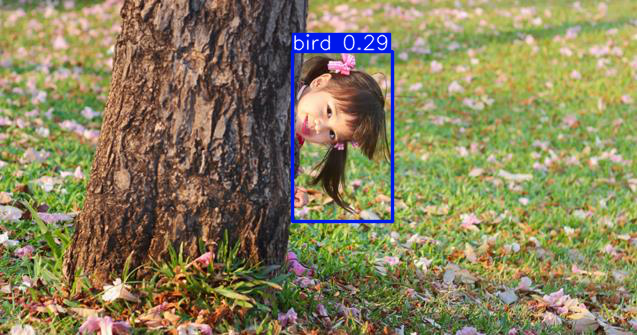

         xmin      ymin       xmax       ymax  confidence  class  name
0  292.150452  51.38649  392.23999  221.99379    0.290816     14  bird

Demonstrating model bias:


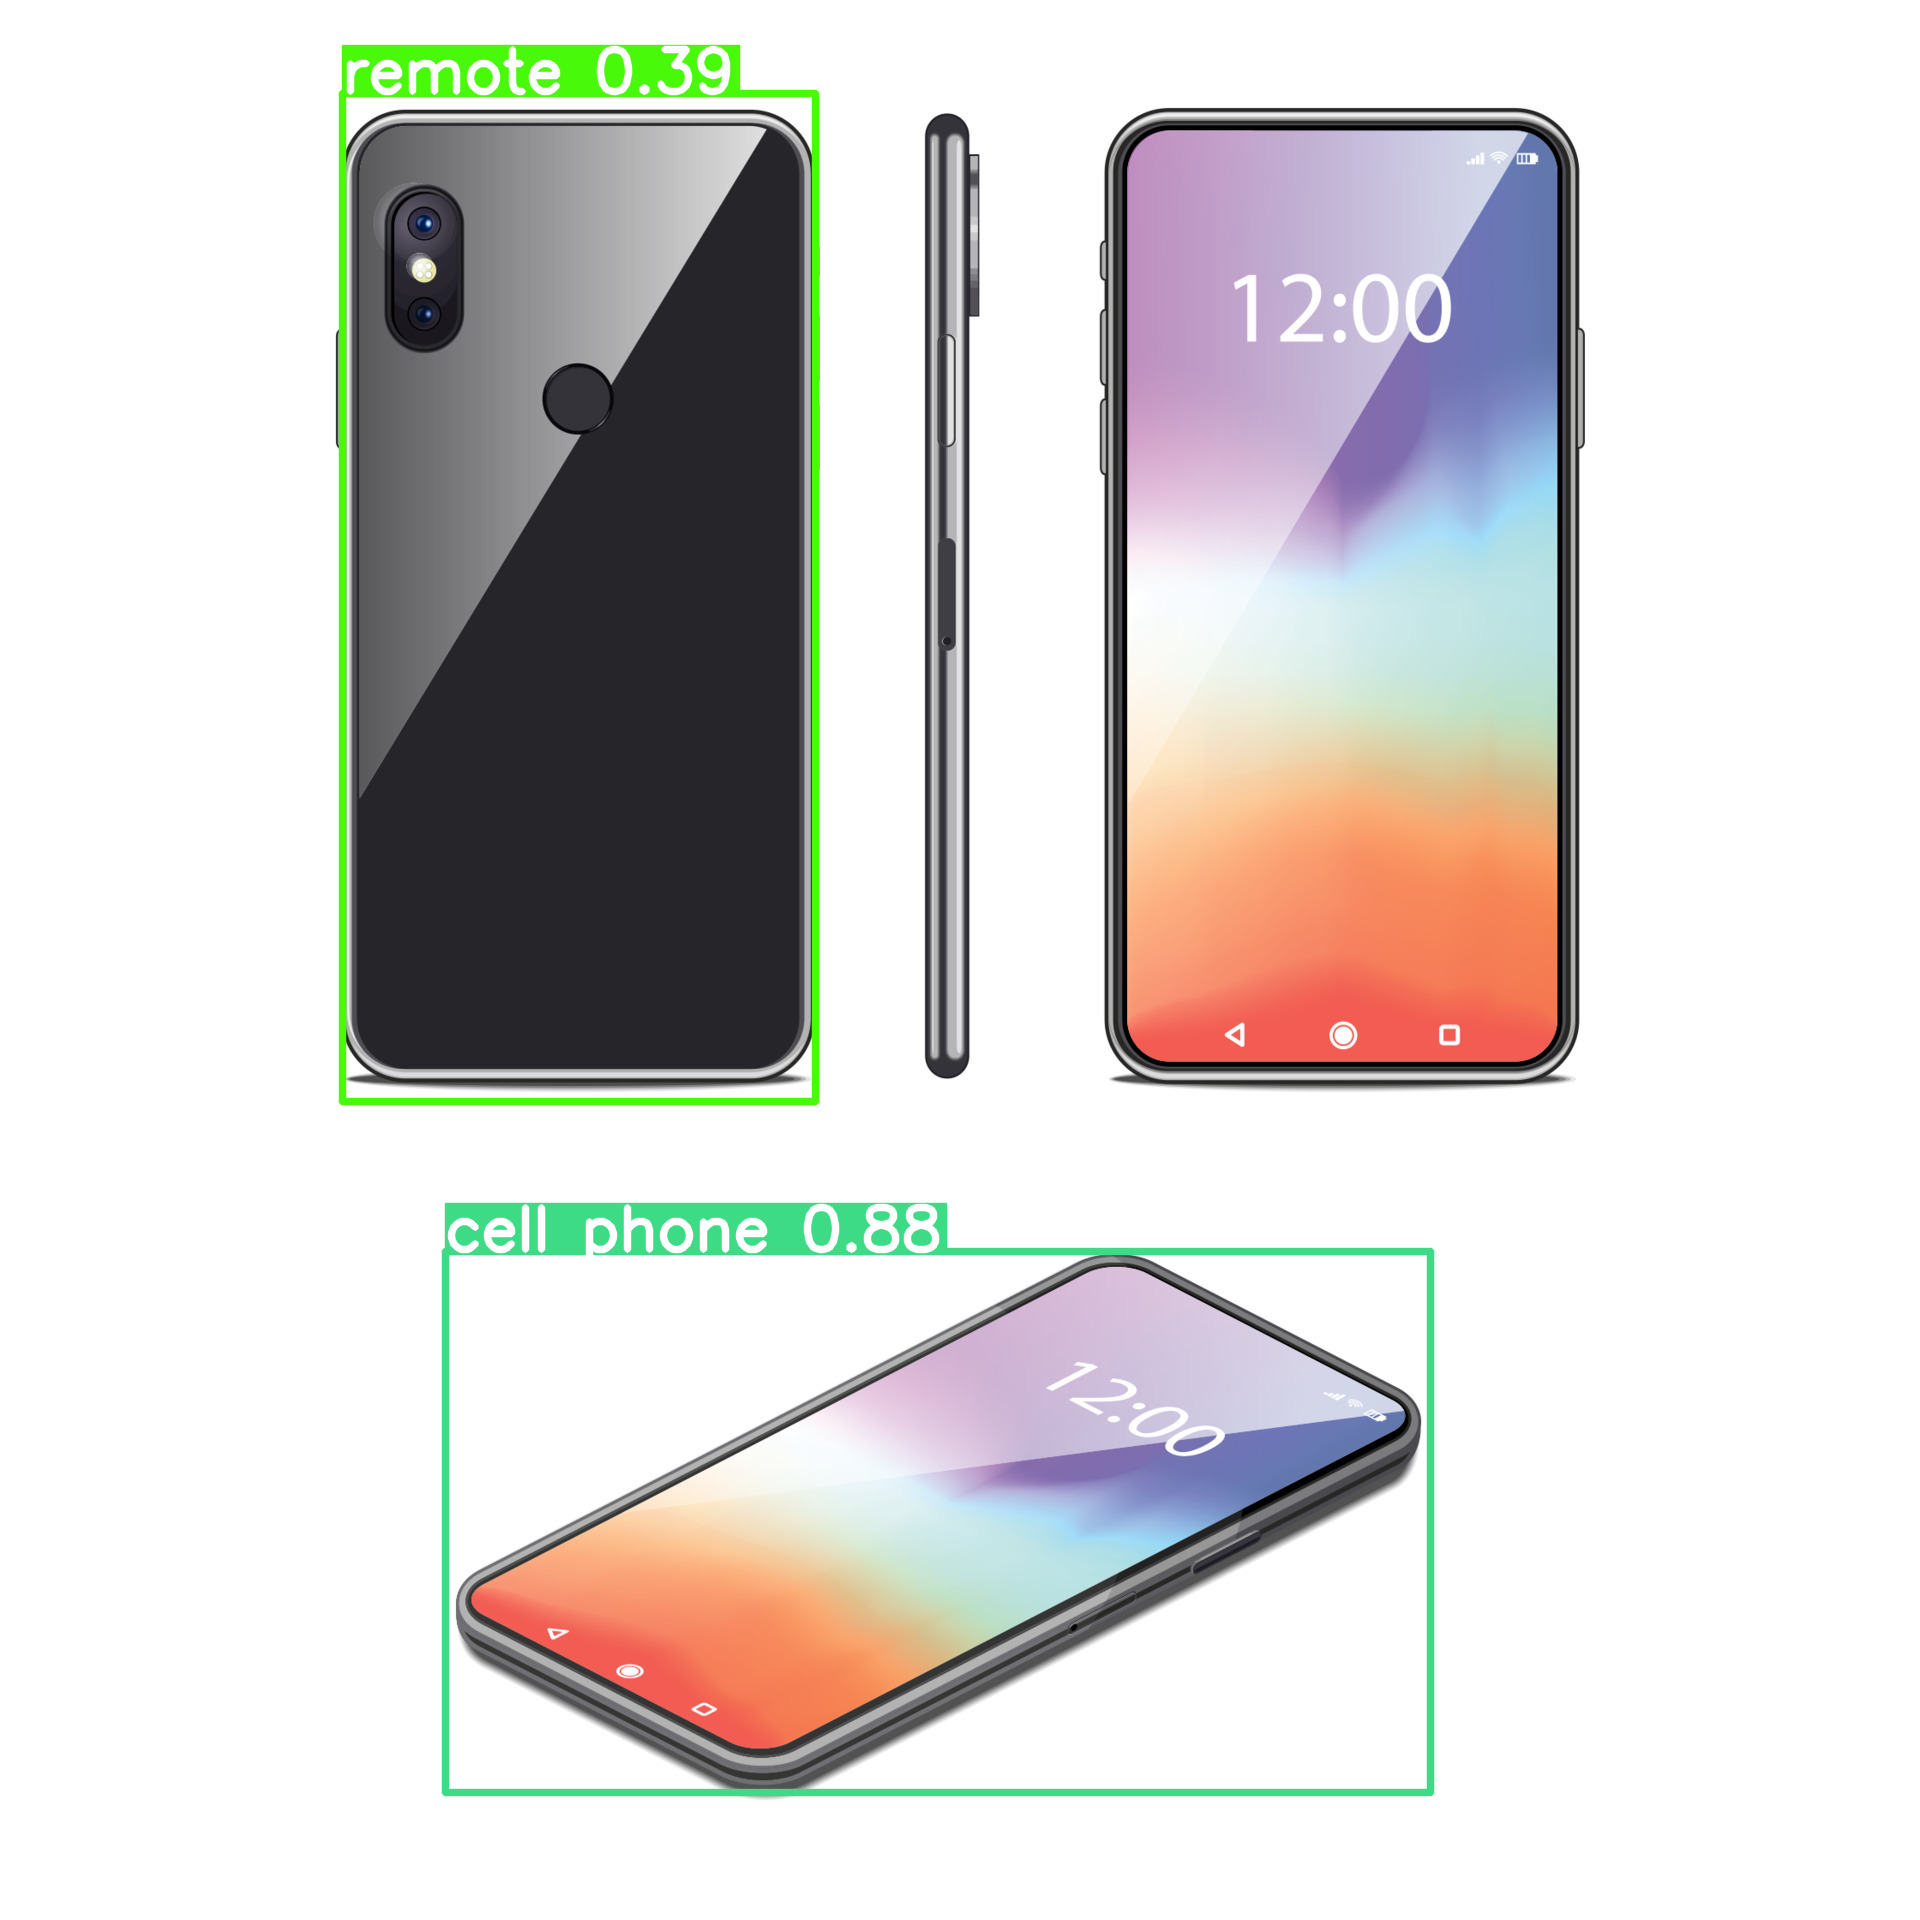

         xmin         ymin         xmax         ymax  confidence  class   
0  445.193329  1251.814087  1430.635254  1792.678101    0.880508     67  \
1  342.662903    93.861008   815.978271  1101.983398    0.394383     65   

         name  
0  cell phone  
1      remote  

Demonstrating blurring:


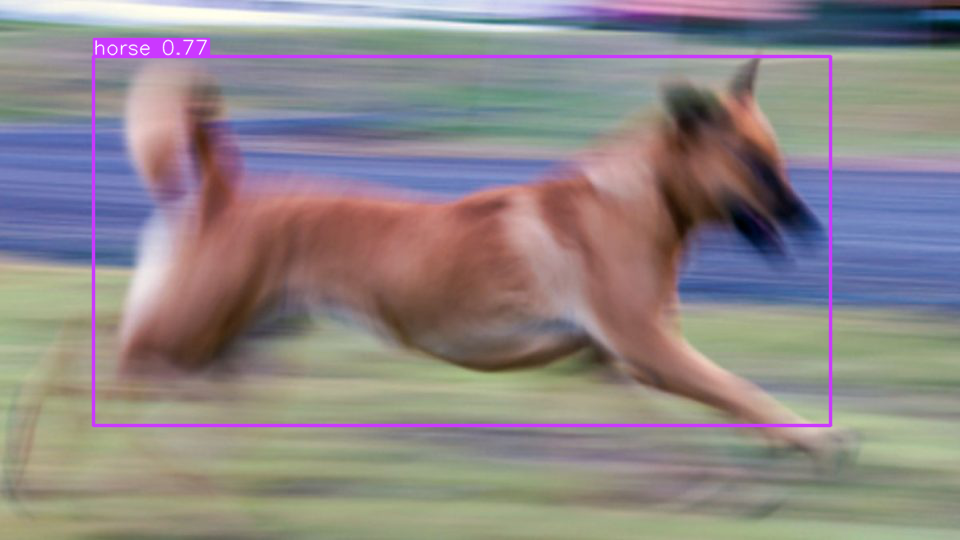

        xmin       ymin        xmax        ymax  confidence  class   name
0  93.195099  56.552513  830.170715  425.511475    0.768481     17  horse


In [5]:
#Insert the inference code here.

# Images
img1 = 'taken_imgs/occlusion-kid.jpg'  
img2 = 'taken_imgs/bias-cellphone.jpg' 
img3 = 'taken_imgs/blurry-dog.jpg'

# show the results
print('Demonstrating occlusion:')
results = model(img1)
results.show()
print(results.pandas().xyxy[0])

print('\nDemonstrating model bias:')
results = model(img2)
results.show()
print(results.pandas().xyxy[0])

print('\nDemonstrating blurring:')
results = model(img3)
results.show()
print(results.pandas().xyxy[0])

### Question 3

Analyize the results of the inference. 
1. How well did the model detect the objects in the pictures? explain.


In [6]:
display_answer(hw2.answers.part6_q3)



**Your answer:**

The model detected the objects in the pictures very badly (again the detection of boundaries was good, but a total misclassification was demonstrated):

- In the occlusion demonstration picture, a child's body was hidden behind a tree, such that only her head was appearing.
The child was classified as a bird instead of a person, but with a relatively low confidence level - 0.29.

- In the model bias demonstration picture, a cell phone was caught in different views (front, side, back and angular). 
The front and the side views were not detected at all, whereas the back view was classified as a remote. Only the angular view was classified correctly (with high confidence level!).

- In the blurring demonstration picture, a running dog was caught without a proper focus - thus the obtained picture was blurred. 
The dog was classified as a horse with a high confidence level - 0.77.

These all imply some limitations in the model's abilities, leading to poor performance in the given situations.


## Bonus 
<a id=part6_3></a>

Try improving the model performance over poorly recognized images by changing them. 
Describe the manipulations you did to the pictures.

Trying to fix occlusion:


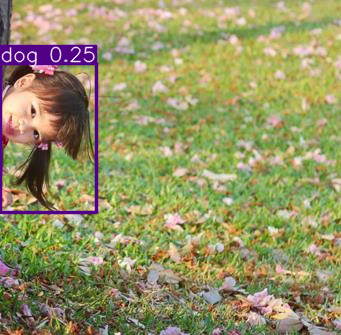

   xmin       ymin       xmax        ymax  confidence  class name
0   0.0  63.162506  96.066895  212.445648    0.250114     16  dog

Trying again to fix occlusion:


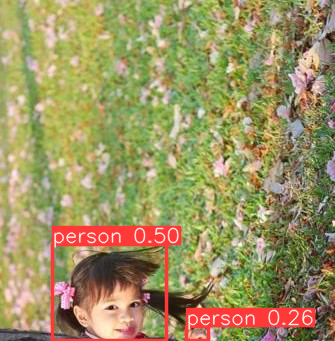

         xmin        ymin        xmax        ymax  confidence  class    name
0   52.833168  244.141891  166.887955  340.508942    0.499462      0  person
1  186.226654  326.784576  208.420319  340.992157    0.258678      0  person

Trying to fix model bias:


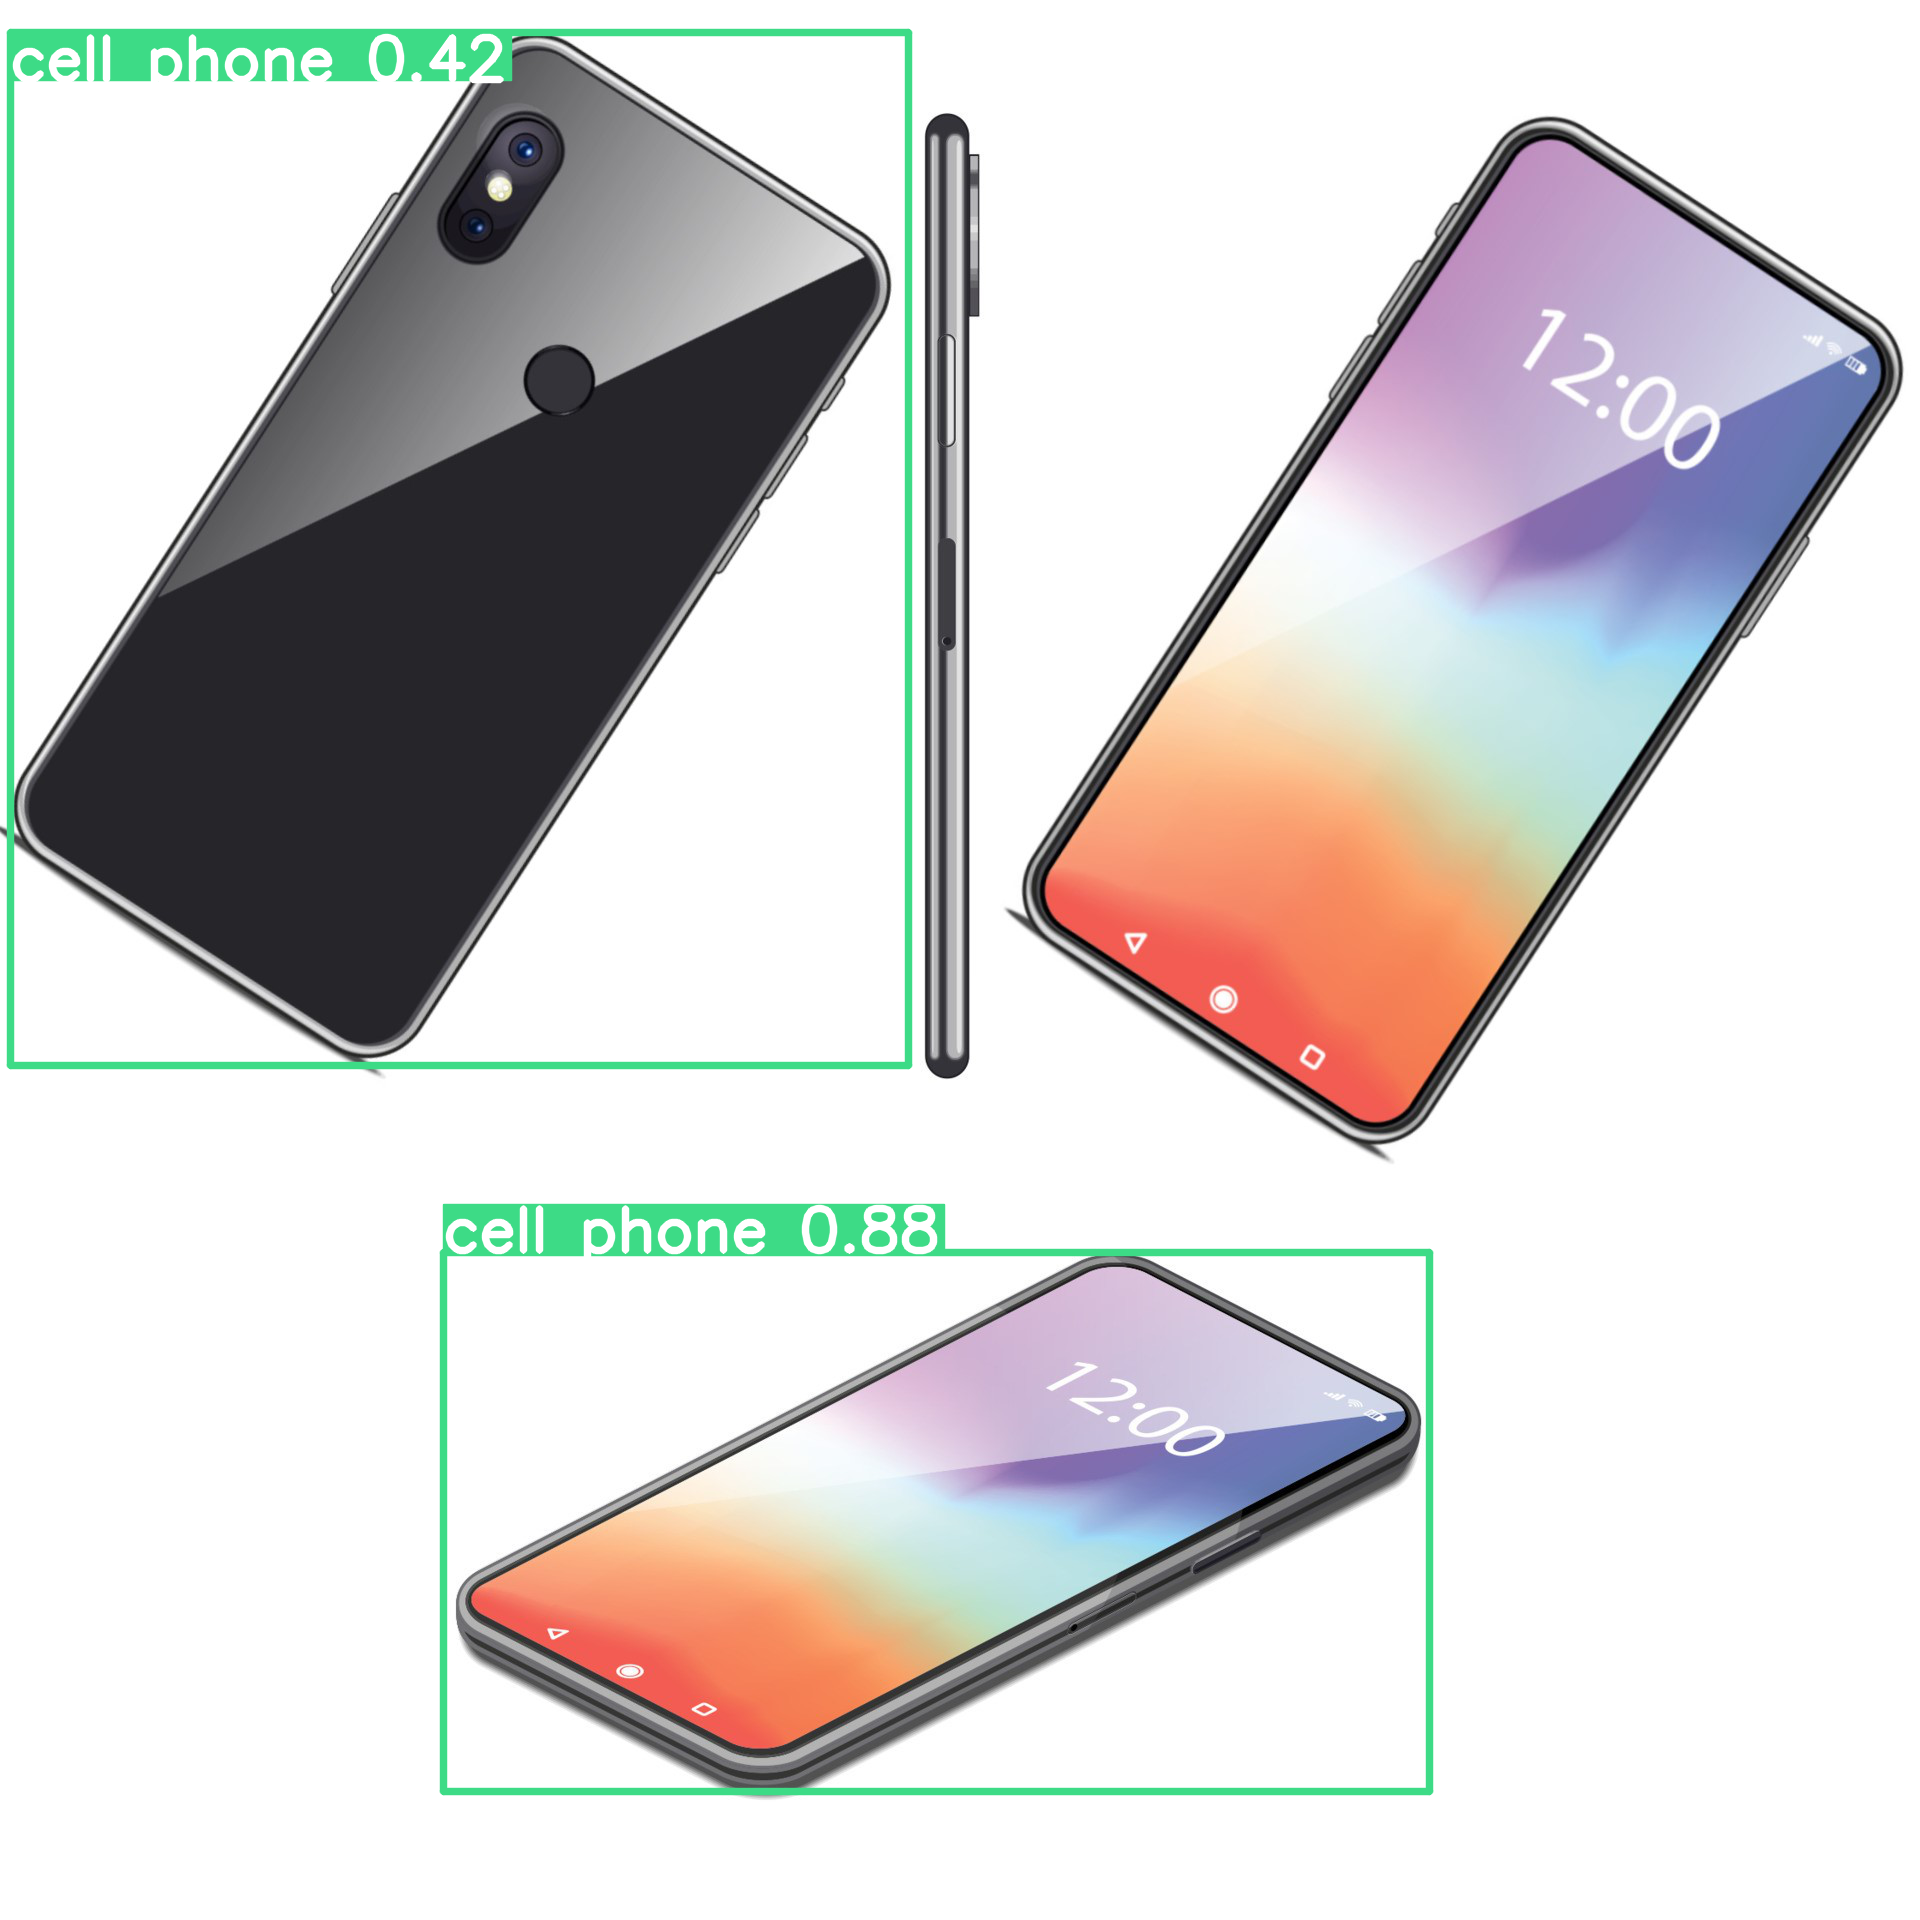

         xmin         ymin         xmax         ymax  confidence  class   
0  443.160492  1252.394531  1429.164673  1791.688843    0.876003     67  \
1   10.093597    32.694489   908.030273  1065.914673    0.421801     67   

         name  
0  cell phone  
1  cell phone  

Trying to fix blurring:


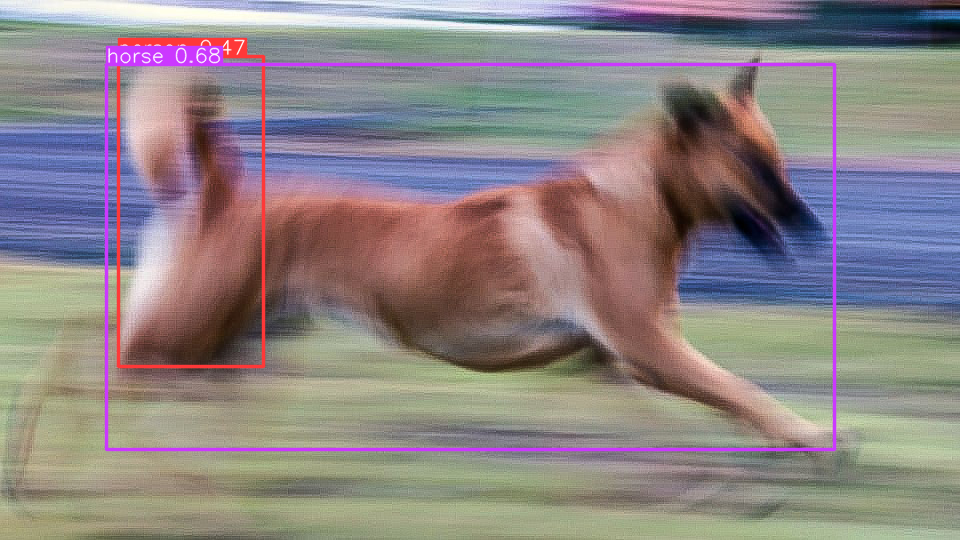

         xmin       ymin        xmax        ymax  confidence  class    name
0  106.199364  64.852112  834.129150  449.548370    0.680178     17   horse
1  118.411469  56.951603  263.671906  366.091095    0.474996      0  person


In [7]:
#Insert the inference code here.

# Images
img1 = 'taken_imgs/occlusion-kid-fix.jpg'  
img1_1 = 'taken_imgs/occlusion-kid-fix2.jpg'  
img2 = 'taken_imgs/bias-cellphone-fix.jpg' 
img3 = 'taken_imgs/blurry-dog-fix.jpg'

# show the fixes results
print('Trying to fix occlusion:')
results = model(img1)
results.show()
print(results.pandas().xyxy[0])

print('\nTrying again to fix occlusion:')
results = model(img1_1)
results.show()
print(results.pandas().xyxy[0])

print('\nTrying to fix model bias:')
results = model(img2)
results.show()
print(results.pandas().xyxy[0])

print('\nTrying to fix blurring:')
results = model(img3)
results.show()
print(results.pandas().xyxy[0])

In [8]:
display_answer(hw2.answers.part6_bonus)



**Your answer:**


Trying to improve the model's performance on the previous pictures, we made the following manipulations:

- In the occlusion demonstration picture, At first we cropped the tree from the image - yielding another misclassification of the child - dog class with confidence level of 0.25.
The change of classification indicated that the occlusion with the tree had some influence on the detection.
We assumed that in addition to the occlusion, model bias is involved due to the rotated face of the child (parallel to the ground), so in order to fix that - we now also performed
a counter-rotation to the image, resulted with a correct classification of the child - person class with confidence level of 0.50.

- In the model bias demonstration picture, Seeing that only the angular view was classified correctly - We rotated by 45 degrees the front and the back views of the cell phones.
The result was a correct classification of the back view - cell phone class with confidence level of 0.42 (which was a bit low for what we expected).
Unfortunately, the rotated front view was still not detected at all, a result that is probably related to training bias - where images of cell phones were taken mainly on angular views (not only rotated).

- In the blurring demonstration picture, we tried to sharpen the image and clarify it, using some common filters.
The result was still noisy and blurred, though it became a bit clearer, hence the model again misclassified it - this time it detected two objects, horse (same box as earlier, this time with lower confidence level of 0.68)
and a person (over the dog's tail area). From what we understand, the sharpening manipulation might had amplified some noise in this region of the image, which became now more noticable and mislead the model to detect another object. 

In summery, the manipulations we've performed indeed improved the model's performance over the poorly recognized images.
It involved some spatial manipulations like rotation and cropping, along with fine-tuning filters like the sharpening, resulting in a correct classification for the majority of the images.
It is worth to mention that for some situations (like the blurred dog image), a more sophisticated manipulation is required to correctly classify the required objects.
